In [1]:
from load_data import * 
from helpers import mtanh, calculate_pressure, normal_distribution, TransParams, solve_pde, T_model, n_model, get_chi_inter, get_d_inter, BCS, solve_time_evolution, calculate_bohmgrybohm_from_jardin, calculate_bohmdiffusion

import matplotlib.pyplot as plt 
import scienceplots 
import os 
import sys 
plt.style.use(['science', 'grid'])

from scipy.integrate import simpson, trapezoid, romb
from scipy.signal import find_peaks, stft 


In [2]:
BASE_PULSE_DIR = "/home/akadam/EUROfusion/2024/data"
shot_num = 83625
PULSE_STRUCT_DIR = os.path.join(BASE_PULSE_DIR, f"jet_{shot_num}")
JET_PDB_DIR = "/home/akadam/EUROfusion/2024/data"
FIGURE_DIR = '/home/akadam/EUROfusion/2024/pedestal_transport/models/data_driven/figures'
pulse = load_single_pulse_struct(PULSE_STRUCT_DIR)
relevant_profiles = pulse.return_profiles_in_time_windows()

""" aSk ThE EXPEriMENTalIsTs """
if shot_num == 83624:
    offset = 0.046
elif shot_num == 83625:
    offset = 0.041
elif shot_num == 83627:
    offset = 0.043
elif shot_num == 83628:
    offset = 0.052
elif shot_num == 83630: 
    offset = 0.045
elif shot_num == 83631:
    offset = 0.0384
elif shot_num == 83633:
    offset = 0.04
elif shot_num == 83637:
    offset = 0.044
elif shot_num == 83640:
    offset = 0.045
else: 
    offset = 0.0

print(relevant_profiles.hrts_times[-1] - relevant_profiles.hrts_times[0])

COLOR_RED = '#CC6677'
COLOR_GREEN = "#117733"
COLOR_BLUE = "#332288"
COLOR_YELLOW = "#DDCC77"


3.6518822


In [3]:
normed_tbeo = (pulse.tbeo.data - pulse.tbeo.data.mean() ) / pulse.tbeo.data.std()

delta_t = pulse.tbeo.time[1] - pulse.tbeo.time[0]
distance_between_elms = int(200E-6 / delta_t)*20
threshold_height = normed_tbeo.std()*2

peaks, _ = find_peaks(normed_tbeo, height=threshold_height, distance=distance_between_elms)
adjusted_peaks = np.empty_like(peaks)
# TODO: SHIFT THE TBEO SIGNAL BY SOME TIME 
for i, pk in enumerate(peaks): 
    for k in range(30): 
        if normed_tbeo[pk - k] < 0: 
            zero_crossing = pk-k +1
            break 
        else: 
            zero_crossing = pk 
    adjusted_peaks[i] = zero_crossing

# peaks -= 8
elm_times = pulse.tbeo.time[peaks] # - 500E-6
# elm_times   = pulse.tbeo.time[adjusted_peaks]
tau_interelms_from_expdata = []
for i in range(len(elm_times) - 1): 
    tau_interelms_from_expdata.append(elm_times[i+1] - elm_times[i])

elm_frequency = len(peaks) / (pulse.tbeo.time[-1] - pulse.tbeo.time[0])
print(elm_frequency)

t_minus_t_elm = np.empty(len(relevant_profiles.hrts_times))

for i, t in enumerate(relevant_profiles.hrts_times):
    nearest_elm_idx = np.argmin(np.abs(elm_times - t))
    t_nearest_elm = elm_times[nearest_elm_idx]    
    t_minus_t_elm[i] = t - t_nearest_elm


36.60767477719484


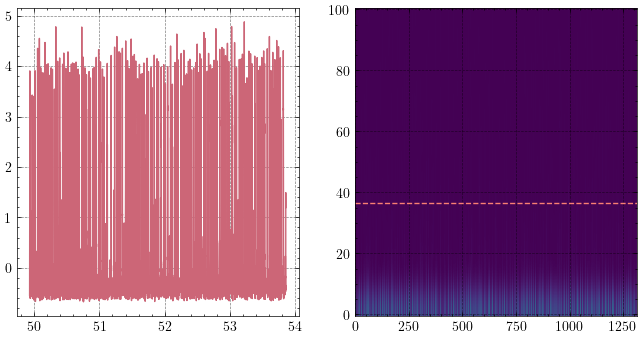

In [41]:
from matplotlib.colors import LogNorm
from scipy.signal.windows import gaussian
from scipy.signal import ShortTimeFFT



T_x  = 1/(pulse.tbeo.time[1] - pulse.tbeo.time[0])
t_x  = pulse.tbeo.time 
N    = len(t_x)
x    = pulse.tbeo.data

g_std = 5
w     = gaussian(100, std=g_std, sym=True)
SFT   = ShortTimeFFT(w, hop=30, fs=T_x, mfft=200, scale_to='magnitude')
Sx    = SFT.stft(x)


fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(pulse.tbeo.time, normed_tbeo, color=COLOR_RED)

axs[1].imshow(abs(Sx), aspect='auto', origin='lower')
axs[1].axhline(elm_frequency, color='salmon', linestyle='--')

36.60767477719484


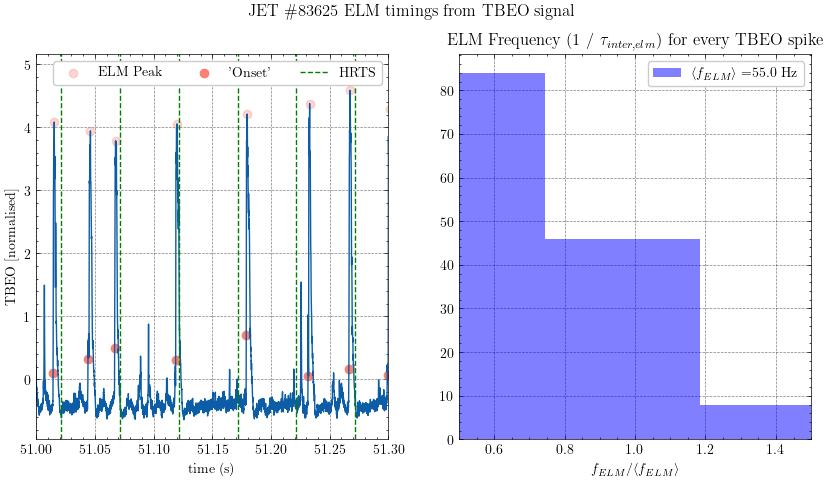

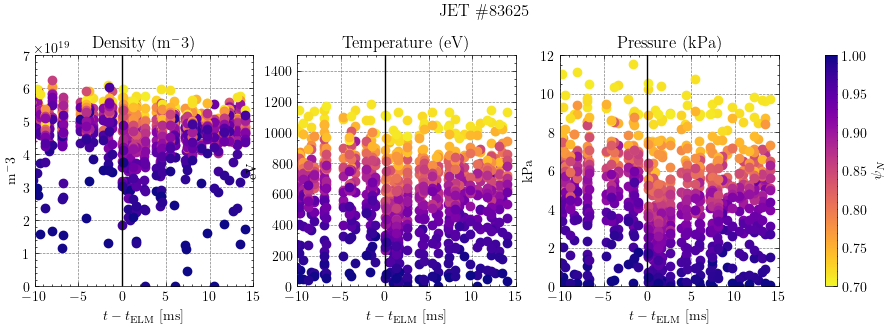

In [12]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(pulse.tbeo.time, normed_tbeo)
axs[0].scatter(pulse.tbeo.time[peaks], normed_tbeo[peaks], color='salmon', alpha=0.3, label='ELM Peak')
axs[0].scatter(pulse.tbeo.time[adjusted_peaks], normed_tbeo[adjusted_peaks], color='salmon', label='\'Onset\'')
# axs.axhline(threshold_height, color='black')
for i, t in enumerate(relevant_profiles.hrts_times): 
    if i == 0: 
        label = 'HRTS'
    else: 
        label = None
    axs[0].axvline(t, color='green', linestyle='--', label=label)
axs[0].set_xlim(51.0, 51.3)
axs[0].legend(ncols=3)
elm_frequencies = 1.0 / np.array(tau_interelms_from_expdata)

axs[1].hist(elm_frequencies / np.mean(elm_frequencies), bins=20, color='blue', alpha=0.5, label=r'$\langle f_{ELM} \rangle = $' + f'{np.mean(elm_frequencies):.1f} Hz')
axs[1].set_title(r'ELM Frequency (1 / $\tau_{inter, elm}$) for every TBEO spike')
axs[1].set_xlabel(r'$f_{ELM} / \langle f_{ELM} \rangle$')
axs[0].set_xlabel('time (s)')
axs[0].set_ylabel('TBEO [normalised]')
axs[1].set_xlim(0.5, 1.5)
fig.suptitle(f'JET \#{shot_num} ELM timings from TBEO signal')
axs[1].legend()
savename = os.path.join(FIGURE_DIR, f'jet_{shot_num}_elm_timings-and-avgelm-freqs')
# fig.savefig(savename, dpi=300, transparent=True)

plt.show()


cmap = plt.cm.plasma_r
norm = plt.Normalize(0.7, 1.0)

fig, axs = plt.subplots(1, 3, figsize=(12, 3))

below_0, above_0 = [], [] 
for i, t in enumerate(t_minus_t_elm): 
    pedestal_region = (relevant_profiles.hrts_psi[i] + offset) > 0.70
    inside_sep      = np.logical_and((relevant_profiles.hrts_psi[i] + offset) > 0.7, (relevant_profiles.hrts_psi[i] + offset) < 1.0)
    pressure_all = calculate_pressure(relevant_profiles.te[i]*1E-3, relevant_profiles.ne[i]*1E-19)*1000.0
    pressure_ped = calculate_pressure(relevant_profiles.te[i, inside_sep]*1E-3, relevant_profiles.ne[i, inside_sep]*1E-19)*1000.0
    # stored_energy = trapezoid(pressure) * 1E-6 # , x=relevant_profiles.hrts_psi[i, inside_sep] + offset in MJ
    # axs[3].scatter(t*1000, stored_energy, color='black')
    stored_energy_all = simpson(pressure_all, x=relevant_profiles.hrts_psi[i] + offset) * 1E-6 # ,  in MJ
    stored_energy_ped = simpson(pressure_ped, x=relevant_profiles.hrts_psi[i, inside_sep] + offset) * 1E-6 # ,  in MJ
    frac_stored_energy = stored_energy_ped / stored_energy_all
    # axs[3].scatter(t*1000, frac_stored_energy, color='red')
    if t*1000 < 0.0 and t*1000 > -5.0:
        below_0.append(stored_energy_ped)
    elif t*1000 > 0.2 and t*1000 < 5.0:
        above_0.append(stored_energy_ped)
    # stored_energy = romb(pressure, x=relevant_profiles.hrts_psi[i, inside_sep] + offset)
    # axs[3].scatter(t*1000, stored_energy, color='green')
    for k in range(len(relevant_profiles.hrts_psi[i, pedestal_region])): 
        psi_val = relevant_profiles.hrts_psi[i, pedestal_region][k] + offset
        if psi_val > 1.0: 
            continue 
        
        color = cmap(norm(psi_val))
        # print(relevant_profiles.hrts_psi[i, pedestal_region][k] + offset)
        dens_psi_09 = relevant_profiles.ne[i, pedestal_region][k]
        temp_psi_09 = relevant_profiles.te[i, pedestal_region][k]
        if psi_val > 0.9 and temp_psi_09 > 1000: 
            continue 
        pres_psi_09 = calculate_pressure(temp_psi_09*1E-3, dens_psi_09*1E-19)
        axs[0].scatter(t*1000, dens_psi_09, color=color)
        axs[1].scatter(t*1000, temp_psi_09, color=color)
        axs[2].scatter(t*1000, pres_psi_09, color=color)
    
avg_below_0 = np.mean(below_0)
avg_above_0 = np.mean(above_0)
# axs[3].axhline(avg_below_0, color='black')
# axs[3].axhline(avg_above_0, color='green')
# plot colorbar 
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[:3], label=r'$\psi_N$')
axs[0].set_ylim(0.0, 7.0E19)
axs[1].set_ylim(0.0, 1500)
axs[2].set_ylim(0.0, 12.0)

axs[0].set_title('Density (m$^-3$)')
axs[1].set_title('Temperature (eV)')
axs[2].set_title('Pressure (kPa)')
axs[0].set_ylabel('m$^-3$')
axs[1].set_ylabel('eV')
axs[2].set_ylabel('kPa')


for ax in axs: 
    ax.set_xlabel(r'$t - t_{\text{ELM}}$ [ms]')
    ax.set_xlim(-10, 15)
    ax.axvline(0.0, color='black')

fig.suptitle(f'JET \#{shot_num}', y=1.05)
savename = os.path.join(FIGURE_DIR, f'jet_{shot_num}_t-minus-telm-hrts')
# fig.savefig(savename, dpi=300, transparent=True)


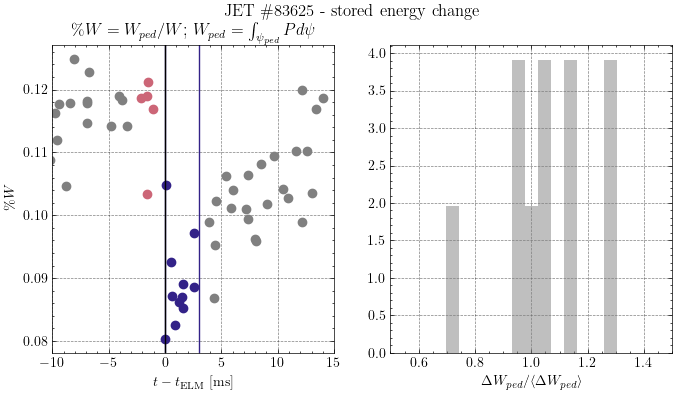

[3, 44, 51, 60, 63] [10, 12, 17, 21, 25, 41, 49, 65, 67, 69, 73]
3 -0.001644134521484375 50.221054
44 -0.0015869140625 52.272114
51 -0.00110626220703125 52.622295
60 -0.00217437744140625 53.072525
63 -0.001495361328125 53.222603


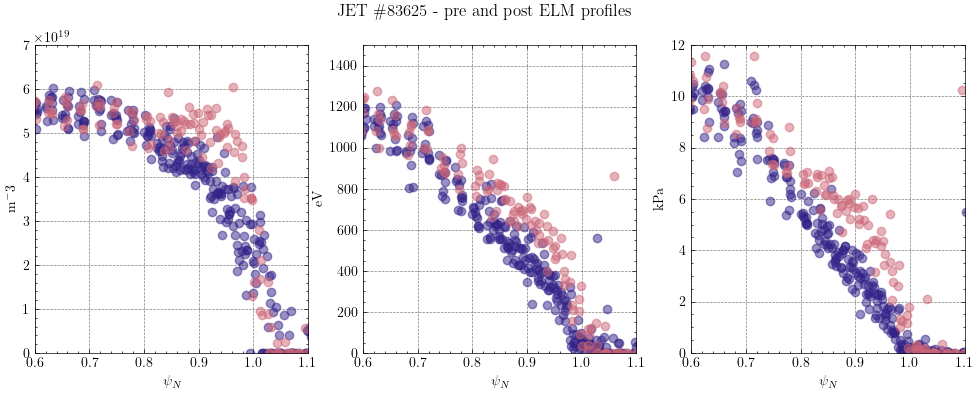

In [21]:

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot the stored energy one
pre_elm_stored_energy = 0.0016 # 115
change_in_stored_energies = []
tau_interelm_associated   = []

T_CUTOFF = 3.0
pre_elm_profiles, post_elm_profiles = [], []
for i, t in enumerate(t_minus_t_elm): 
    pedestal_region = (relevant_profiles.hrts_psi[i] + offset) > 0.90
    inside_sep      = np.logical_and((relevant_profiles.hrts_psi[i] + offset) > 0.7, (relevant_profiles.hrts_psi[i] + offset) < 1.0)
    pressure_all = calculate_pressure(relevant_profiles.te[i]*1E-3, relevant_profiles.ne[i]*1E-19)*1000.0
    pressure_ped = calculate_pressure(relevant_profiles.te[i, inside_sep]*1E-3, relevant_profiles.ne[i, inside_sep]*1E-19)*1000.0
    # stored_energy = trapezoid(pressure) * 1E-6 # , x=relevant_profiles.hrts_psi[i, inside_sep] + offset in MJ
    # axs[3].scatter(t*1000, stored_energy, color='black')
    stored_energy_all = simpson(pressure_all, x=relevant_profiles.hrts_psi[i] + offset) * 1E-6 # ,  in MJ
    stored_energy_ped = simpson(pressure_ped, x=relevant_profiles.hrts_psi[i, inside_sep] + offset) * 1E-6 # ,  in MJ
    frac_stored_energy = stored_energy_ped / stored_energy_all
    
    
    if t*1000 > 0.0 and t*1000 < T_CUTOFF:#  and stored_energy_ped < pre_elm_stored_energy:
        change_in_stored_energies.append(pre_elm_stored_energy- stored_energy_ped)
        tau_interelm_associated.append(tau_interelms_from_expdata[i])
        post_elm_profiles.append(i)
        color = COLOR_BLUE
    elif t*1000 < 0.0 and t*1000 > -T_CUTOFF:
        pre_elm_profiles.append(i)
        color = COLOR_RED
    else: 
        color = 'grey'
    axs[0].scatter(t*1000, frac_stored_energy, color=color)

change_in_stored_energies = np.array(change_in_stored_energies)
axs[0].set_title(r'$\% W = W_{ped}/W$; $W_{ped} = \int_{\psi_{ped}} P d\psi$')
axs[0].set_xlabel(r'$t - t_{\text{ELM}}$ [ms]')

# axs[0].hlines(0.115, -10, 0, color='black')
for _t in [0, T_CUTOFF]: 
    axs[0].axvline(_t, color=COLOR_BLUE)
axs[0].set_xlim(-10, 15)
axs[0].axvline(0.0, color='black')
axs[0].set_ylabel(r'$\%  W$  ')
# Plot the histogram of change in stored energies / average change in stored energy 
axs[1].hist(change_in_stored_energies / np.mean(change_in_stored_energies), bins=20, color='grey', alpha=0.5, density=True)
axs[1].set_xlim(0.5, 1.5)
axs[1].set_xlabel(r'$\Delta W_{ped} / \langle \Delta W_{ped} \rangle$')
savename = os.path.join(FIGURE_DIR, f'jet_{shot_num}_stored_energy_change')

fig.suptitle(f'JET \#{shot_num} - stored energy change')

fig.savefig(savename, dpi=300, transparent=True)

plt.show()

fig, axs = plt.subplots(1, 3, figsize=(4*3, 4))
print(pre_elm_profiles, post_elm_profiles)

for i in post_elm_profiles:
    x = relevant_profiles.hrts_psi[i] + offset 
    axs[0].scatter(x, relevant_profiles.ne[i], color=COLOR_BLUE, alpha=0.5)
    axs[1].scatter(x, relevant_profiles.te[i], color=COLOR_BLUE, alpha=0.5)
    axs[2].scatter(x, calculate_pressure(relevant_profiles.te[i]*1E-3, relevant_profiles.ne[i]*1E-19), color=COLOR_BLUE, alpha=0.5)

for i in pre_elm_profiles:
    x = relevant_profiles.hrts_psi[i] + offset 
    print(i, t_minus_t_elm[i], relevant_profiles.hrts_times[i])
    axs[0].scatter(x, relevant_profiles.ne[i], color=COLOR_RED, alpha=0.5)
    axs[1].scatter(x, relevant_profiles.te[i], color=COLOR_RED, alpha=0.5)
    axs[2].scatter(x, calculate_pressure(relevant_profiles.te[i]*1E-3, relevant_profiles.ne[i]*1E-19), color=COLOR_RED, alpha=0.5)

fig.suptitle(f'JET \#{shot_num} - pre and post ELM profiles')
for ax in axs: 
    ax.set_xlabel(r'$\psi_N$')
    ax.set_xlim(0.6, 1.1)

axs[0].set_ylim(0.0, 7.0E19)
axs[1].set_ylim(0.0, 1500)
axs[2].set_ylim(0.0, 12.0)
axs[0].set_ylabel('m$^-3$')
axs[1].set_ylabel('eV')
axs[2].set_ylabel('kPa')

plt.show()

(15,) (15,)


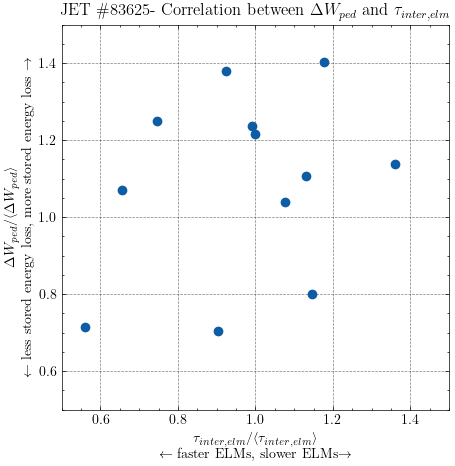

In [68]:
x, y = np.array(tau_interelm_associated) / np.mean(tau_interelm_associated), change_in_stored_energies / np.mean(change_in_stored_energies)
print(x.shape, y.shape)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# counts, ybins, xbins, image = plt.hist2d(x, y, bins=5)
plt.scatter(x, y)
ax.set_xlim(0.5, 1.5)
ax.set_ylim(0.5, 1.5)
ax.set_xlabel(r'$\tau_{inter, elm} / \langle \tau_{inter, elm} \rangle$' + '\n $\leftarrow$ faster ELMs, slower ELMs' +r'$\rightarrow$')
ax.set_ylabel(r'$\Delta W_{ped} / \langle \Delta W_{ped} \rangle$' + '\n' + r'$\leftarrow$ less stored energy loss, more stored energy loss $\rightarrow$')
# fig.colorbar(image, ax=ax, label='Counts')
ax.set_title(f'JET \#{shot_num}' + r'- Correlation between $\Delta W_{ped}$ and $\tau_{inter, elm}$')
plt.show()

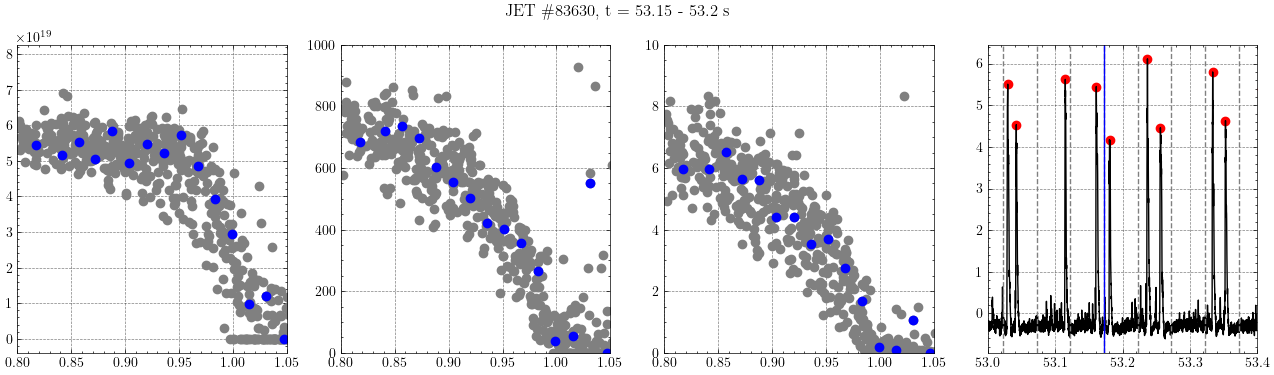

In [44]:
interested_hrts_window = np.logical_and(relevant_profiles.hrts_times > 53.15, relevant_profiles.hrts_times < 53.2)
interested_hrts_times = relevant_profiles.hrts_times[interested_hrts_window]
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

axs[0].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne, color='grey', label='Temperature')
axs[0].scatter(relevant_profiles.hrts_psi[interested_hrts_window] + offset, relevant_profiles.ne[interested_hrts_window], color='blue', label='Density')    
axs[1].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te, color='grey', label='Temperature')
axs[1].scatter(relevant_profiles.hrts_psi[interested_hrts_window] + offset, relevant_profiles.te[interested_hrts_window], color='blue', label='Density')
axs[2].scatter(relevant_profiles.hrts_psi + offset, calculate_pressure(relevant_profiles.te*1E-3, relevant_profiles.ne*1E-19), color='grey', label='Temperature')
axs[2].scatter(relevant_profiles.hrts_psi[interested_hrts_window] + offset, calculate_pressure(relevant_profiles.te[interested_hrts_window]*1E-3, relevant_profiles.ne[interested_hrts_window]*1E-19), color='blue', label='Density')

axs[1].set_ylim(0, 1000)
axs[2].set_ylim(0, 10)
for ax in axs[:3]: 
    ax.set_xlim(0.8, 1.05)


axs[3].plot(pulse.tbeo.time, normed_tbeo, color='black')
axs[3].scatter(pulse.tbeo.time[peaks], normed_tbeo[peaks], color='red')
for i, t in enumerate(relevant_profiles.hrts_times): 
    axs[3].axvline(t, color='grey', linestyle='--')
axs[3].axvline(interested_hrts_times[0], color='blue')

axs[3].set_xlim(53.0, 53.4)

fig.suptitle(f'JET \#{shot_num}, t = 53.15 - 53.2 s')
savepath = '/home/akadam/EUROfusion/2024/pedestal_transport/models/data_driven/figures'
fig.savefig( os.path.join(savepath, f'jet_{shot_num}_t_53_15_53_2.png'))
plt.show()

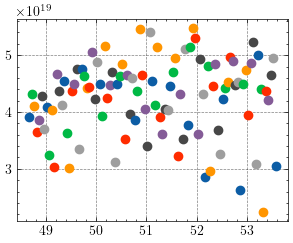

In [30]:
fig = plt.figure()
for i, t in enumerate(relevant_profiles.hrts_times): 
    ped_region = relevant_profiles.hrts_psi[i] > 0.9
    plt.scatter(t, relevant_profiles.ne[i, ped_region][0])

plt.show()

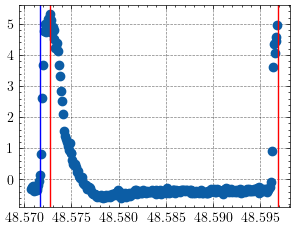

In [43]:
fig, axs = plt.subplots()
for i, pk in enumerate(peaks): 
    for k in range(30): 
        if normed_tbeo[pk - k] < 0: 
            zero_crossing = pk-k +1
            break 
        else: 
            zero_crossing = pk 
    pk2 = peaks[i+1]
    start, stop = pk - 20, pk2
    plt.scatter(pulse.tbeo.time[start:stop],normed_tbeo[start:stop])
    axs.axvline(pulse.tbeo.time[pk], color='red')
    axs.axvline(pulse.tbeo.time[zero_crossing], color='blue')
    axs.axvline(pulse.tbeo.time[pk2], color='red')
    break 
